In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)

In [256]:
with open("data/yelp_academic_dataset_review.json", 'r') as f:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    review_json = '[' + ','.join(f.readlines()) + ']'
# read in the json as a DataFrame
reviews = pd.read_json(review_json)

In [257]:
with open("data/yelp_academic_dataset_tip.json", 'r') as f:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    tip_json = '[' + ','.join(f.readlines()) + ']'
# read in the json as a DataFrame
tips = pd.read_json(tip_json)

In [258]:
set(reviews.columns.tolist()).intersection(tips.columns.tolist())

{u'business_id', u'date', u'text', u'type', u'user_id'}

In [259]:
reviews.shape

(230371, 8)

In [260]:
tips.shape


(24072, 6)

In [261]:
# some nan's will exist because of this where reviews columns and tips columns don't match up
reviews_tips = reviews.append(tips)

In [262]:
reviews_tips.shape

(254443, 9)

In [263]:
reviews_tips.columns = [u'restaurant_id', u'review_date', u'tip_likes', u'review_id', u'review_stars', u'review_text', u'review_type', u'user_id', u'review_votes']

In [264]:
with open("data/yelp_academic_dataset_user.json", 'r') as f:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    user_json = '[' + ','.join(f.readlines()) + ']'
# read in the json as a DataFrame
users = pd.read_json(user_json)

In [265]:
users.columns = [u'user_average_stars', u'user_compliments', u'user_elite', u'user_fans', u'user_friends', u'user_name', u'user_review_count', u'user_type', u'user_id', u'user_votes', u'user_yelping_since']

In [266]:
set(reviews_tips.columns.tolist()).intersection(users.columns.tolist())

{u'user_id'}

In [267]:
users.shape

(68650, 11)

In [268]:
users_reviews_tips = pd.merge(reviews_tips, users, on='user_id')

In [269]:
users_reviews_tips.shape

(254443, 19)

In [270]:
with open("data/yelp_academic_dataset_business.json", 'r') as f:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    restaurant_json = '[' + ','.join(f.readlines()) + ']'
# read in the json as a DataFrame
restaurants = pd.read_json(restaurant_json)

In [271]:
restaurants.columns = [u'restaurant_attributes', u'restaurant_id', u'restaurant_categories', u'restaurant_city', u'restaurant_full_address', u'restaurant_hours', u'restaurant_latitude', u'restaurant_longitude', u'restaurant_name', u'restaurant_neighborhoods', u'restaurant_open', u'restaurant_review_count', u'restaurant_stars', u'restaurant_state', u'restaurant_type']

In [272]:
set(users_reviews_tips.columns.tolist()).intersection(restaurants.columns.tolist())

{u'restaurant_id'}

In [273]:
restaurants.shape

(1930, 15)

In [274]:
restaurants_users_reviews_tips = pd.merge(users_reviews_tips, restaurants, on='restaurant_id')

In [275]:
restaurants_users_reviews_tips.shape

(254443, 33)

In [276]:
with open("data/yelp_academic_dataset_checkin.json", 'r') as f:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    checkin_json = '[' + ','.join(f.readlines()) + ']'
# read in the json as a DataFrame
checkins = pd.read_json(checkin_json)

In [277]:
checkins.columns = [u'restaurant_id', u'checkin_info', u'checkin_type']

In [278]:
set(restaurants_users_reviews_tips.columns.tolist()).intersection(checkins.columns.tolist())

{u'restaurant_id'}

In [279]:
checkins.shape

(1630, 3)

In [280]:
full_features = pd.merge(restaurants_users_reviews_tips, checkins, how='left', on='restaurant_id')

In [281]:
full_features.shape

(254443, 35)

In [282]:
id_map = pd.read_csv("data/restaurant_ids_to_yelp_ids.csv")

In [283]:
id_dict = {}
# each Yelp ID may correspond to up to 4 Boston IDs
for i, row in id_map.iterrows():
    # get the Boston ID
    boston_id = row["restaurant_id"]
    
    # get the non-null Yelp IDs
    non_null_mask = ~pd.isnull(row.ix[1:])
    yelp_ids = row[1:][non_null_mask].values
    
    for yelp_id in yelp_ids:
        id_dict[yelp_id] = boston_id

In [284]:
# replace yelp business_id with boston restaurant_id
map_to_boston_ids = lambda yelp_id: id_dict[yelp_id] if yelp_id in id_dict else np.nan
full_features.restaurant_id = full_features.restaurant_id.map(map_to_boston_ids)


In [197]:
full_features.shape

(254443, 35)

In [329]:
# drop restaurants not found in boston data
full_features = full_features[pd.notnull(full_features.restaurant_id)]

In [330]:
full_features.shape

(252767, 35)

In [295]:
training_response = pd.read_csv("data/train_labels.csv", index_col=None)
training_response.columns = ['inspection_id', 'inspection_date', 'restaurant_id', '*', '**', '***']

In [302]:
training_response.shape

(27088, 6)

In [307]:
training_response.inspection_date = pd.to_datetime(pd.Series(training_response.inspection_date))

In [298]:
set(full_features.columns.tolist()).intersection(training_response.columns.tolist())

{'restaurant_id'}

In [299]:
full_features_response = pd.merge(full_features, training_response, on='restaurant_id')

In [205]:
full_features_response.shape

(4071065, 40)

In [206]:
no_future = full_features_response[full_features_response.inspection_date > full_features_response.review_date]

In [207]:
no_future.shape

(1923796, 40)

In [208]:
no_future[pd.notnull(no_future.restaurant_id)].shape

(1923796, 40)

In [40]:
no_future['time_delta'] = (no_future.inspection_date - no_future.review_date).astype('timedelta64[D]')

restaurant_cats = pd.Categorical.from_array(no_future.restaurant_id)
no_future['restaurant_id_number'] = restaurant_cats.codes

# no_future['vote_cool'] = [i[1]['cool'] for i in no_future.review_votes.iteritems()]
# no_future['vote_funny'] = [i[1]['funny'] for i in no_future.review_votes.iteritems()]
# no_future['vote_useful'] = [i[1]['useful'] for i in no_future.review_votes.iteritems()]
# no_future = no_future.drop('review_votes')


In [1]:
import data_grab
train_df, test_df = data_grab.load_dataframes()

In [3]:
# pd.set_option('display.max_rows', 100)
triplex = train_df.sort('inspection_date').set_index(['restaurant_id','inspection_date', 'review_date'])

In [4]:
triplex.head()

tip_likes               review_id  \
restaurant_id inspection_date review_date                                      
1JEbP4oR      2006-10-04      2009-08-23         NaN  -oeRykmfb4hQj_nCbJhzaQ   
                              2010-08-23         NaN  w3_pFjG0UZuGU0F6mpFvKg   
                              2008-04-28         NaN  6bq0RMIr1sxHjaXnMcFvgg   
                              2010-11-28         NaN  JBrotsf2FTqREoLlQsyUcg   
                              2009-07-04         NaN  zRdsatfS0XlypPzQtxGi2g   

                                           review_stars  \
restaurant_id inspection_date review_date                 
1JEbP4oR      2006-10-04      2009-08-23              1   
                              2010-08-23              4   
                              2008-04-28              4   
                              2010-11-28              4   
                              2009-07-04              3   

                                                                                 review_text  \
restaurant_id inspection_date review_date                                                      
1JEbP4oR      2006-10-04      2009-08-23   dont eat here, i got food poisining, and i see...   
                              2010-08-23   This place makes me happy for two reasons: the...   
                              2008-04-28   Great under new owner, the food is improving! ...   
                              2010-11-28   Our family sticks to the calimari (when they h...   
                              2009-07-04   When I lived in Southie, Fish Pier was about t...   

                                          review_type                 user_id  \
restaurant_id inspection_date review_date                                       
1JEbP4oR      2006-10-04      2009-08-23       review  pZ6PT1plKcPe43bERqZMzw   
                              2010-08-23       review  -2ui9VojWKW2UJlGJyLVYg   
                              2008-04-28       review  wH0AulL7umy2h5zZG7Tqjw   
                              2010-11-28       review  D1V-IlIWoH3UJ7eIrsGamg   
                              2009-07-04       review  IkuSKxJPrOlygcLQqfwdHQ   

                                                                      review_votes  \
restaurant_id inspection_date review_date                                            
1JEbP4oR      2006-10-04      2009-08-23   {u'funny': 0, u'useful': 0, u'cool': 0}   
                              2010-08-23   {u'funny': 0, u'useful': 0, u'cool': 0}   
                              2008-04-28   {u'funny': 0, u'useful': 1, u'cool': 2}   
                              2010-11-28   {u'funny': 0, u'useful': 0, u'cool': 0}   
                              2009-07-04   {u'funny': 0, u'useful': 1, u'cool': 0}   

                                           user_average_stars  \
restaurant_id inspection_date review_date                       
1JEbP4oR      2006-10-04      2009-08-23                 3.14   
                              2010-08-23                 4.11   
                              2008-04-28                 3.94   
                              2010-11-28                 4.23   
                              2009-07-04                 3.55   

                                                                            user_compliments  \
restaurant_id inspection_date review_date                                                      
1JEbP4oR      2006-10-04      2009-08-23                                                  {}   
                              2010-08-23   {u'profile': 1, u'funny': 1, u'hot': 2, u'cool...   
                              2008-04-28                           {u'plain': 1, u'cool': 1}   
                              2010-11-28                           {u'funny': 1, u'cool': 1}   
                              2009-07-04   {u'profile': 1, u'funny': 6, u'cute': 1, u'pla...   

                                                               user_elite  \
restaurant_id insp

In [2]:
def pull_features(df):
    features = df[['time_delta', 'review_text']]
    features.review_text = features.review_text.apply(lambda x: len(x))
    response = df[['*', '**', '***']].astype(np.float64)
    return features, response

In [5]:
X, y = pull_features(train_df)

In [6]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
model = ols.fit(X,y)

In [7]:
model.score(X,y)

0.00015613079400389474

In [8]:
trans_y = pd.DataFrame(y.multiply([1,3,5], axis=1).sum(axis=1), columns=['transformed_score'])
data = pd.concat([X, y], axis=1)
trans_data = pd.concat([X, trans_y], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d1ca650>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1148782d0>]], dtype=object)

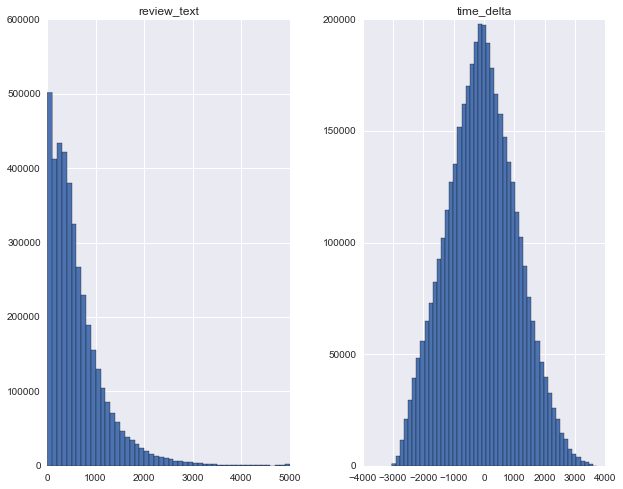

In [57]:
X.hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1cd8c7390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x266939990>]], dtype=object)

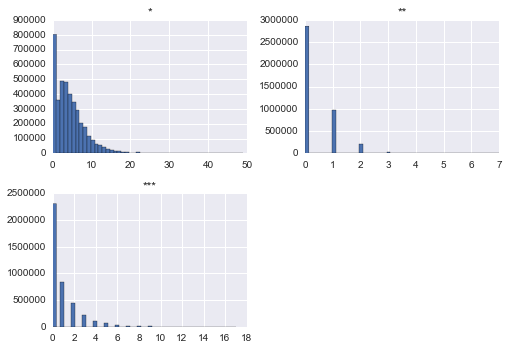

In [221]:
y.hist(bins=50)

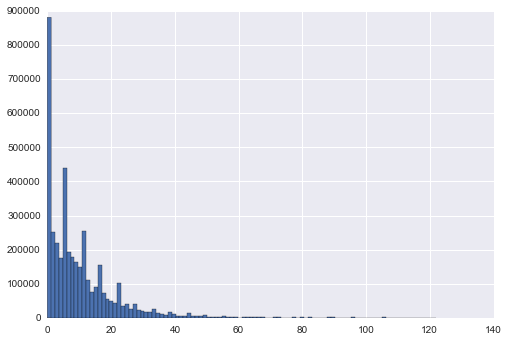

In [155]:
trans_y.hist(bins=100)

In [ ]:
g = sns.FacetGrid(trans_data, margin_titles=True)
g.map(sns.regplot, 'time_delta', 'transformed_score', color=".3", fit_reg=False, x_jitter=.1);

In [ ]:
sns.distplot(X['time_delta'] )

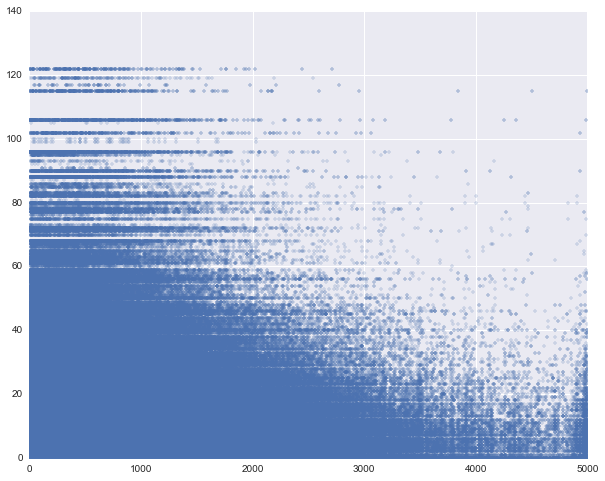

In [50]:
plt.plot(X['review_text'], trans_y, '.', alpha=0.2)

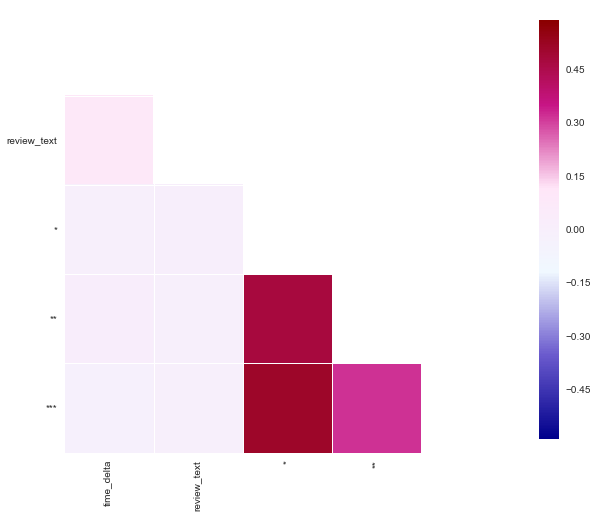

In [169]:
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.blend_palette(["#00008B", "#6A5ACD", "#F0F8FF",
                          "#FFE6F8", "#C71585", "#8B0000"], as_cmap=True)
sns.corrplot(data, annot=False, diag_names=False, cmap=cmap)
ax.grid(False);

In [17]:
from sklearn.cross_validation import cross_val_score
np.mean(cross_val_score(LinearRegression(), X, y, cv=3))

-0.0012309889619115388

In [27]:
Xa=[[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4]]
ya=[[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4]]
cross_val_score(LinearRegression(), Xa, ya, n_jobs=-1)

array([ 1.,  1.,  1.])

In [196]:
X_test, y_test = pull_features(test_df)

In [46]:
X_test.head()

,time_delta,review_text
0,1688,417
1,2680,417
2,596,216
3,1588,216
4,242,1241


In [47]:
predictions = model.predict(X_test)
predictions = np.clip(predictions, 0, np.inf)
# try clipping after averaging scores also

In [48]:
predictions

array([[ 4.23722761,  0.38849799,  0.89294277],
       [ 4.20103984,  0.39877352,  0.86747585],
       [ 4.2653079 ,  0.37757261,  0.92215705],
       ..., 
       [ 4.25066454,  0.3871499 ,  0.89449795],
       [ 4.24599515,  0.38847577,  0.89121189],
       [ 4.28755988,  0.37118072,  0.93805189]])

In [73]:
new_submission = data_grab.get_submission().copy()
# train_labels, train_targets = data_grab.get_response()

In [188]:
temp_df = test_df.copy()
temp_df[['*','**','***']] = predictions

In [208]:
submit_scores = temp_df.groupby(['restaurant_id', 'inspection_date', 'inspection_id'])['*','**','***'].mean()

In [178]:
temp = submit_scores.reset_index().set_index('inspection_id')
indexed = temp.reindex(new_submission.index)

In [85]:
indexed.head()

,restaurant_id,inspection_date,*,**,***
id,,,,,
14916,nkOvZOBW,2014-12-17,4.271066,0.379941,0.913390
29767,WwOaAnOB,2013-12-30,4.276481,0.377986,0.918537
29338,we39kvOk,2011-04-08,4.314311,0.368737,0.940380
7219,dj3d5Xo9,2013-12-30,4.260858,0.384555,0.900714
20979,XJ3rBW3R,2008-03-31,4.316896,0.369364,0.937839


In [95]:
new_submission.iloc[:, -3:] = np.round(indexed[['*','**','***']]).astype(int)

In [96]:
new_submission.head()

,date,restaurant_id,*,**,***
id,,,,,
14916,2014-12-17,nkOvZOBW,4,0,1
29767,2013-12-30,WwOaAnOB,4,0,1
29338,2011-04-08,we39kvOk,4,0,1
7219,2013-12-30,dj3d5Xo9,4,0,1
20979,2008-03-31,XJ3rBW3R,4,0,1


In [97]:
new_submission.to_csv('predictions/ols.csv')

In [ ]:
# incoroprate identical value test into submit and fit function
# average results
# make sure that all of the submission restaurants are in the training set
# make plot for 1, 2, and 3 star separately for each change in feature and plot features alone too
# jitter plots
# why does the submission file have more line items after the prediction file is averaged?
# make feature combining algorithm to choose which increase accuracy
# with predicted scores clipped before and after averaging
# transform all the features
# with and without restaurant_id_number included. technically dont need it because each row corresponds with a restaurant

In [47]:
train_df.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9, 
            ...
            4071055, 4071056, 4071057, 4071058, 4071059, 4071060, 4071061,
            4071062, 4071063, 4071064],
           dtype='int64', length=4071065)